In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support.select import Select
from selenium.common.exceptions import NoSuchElementException
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
from datetime import date,datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date,datetime,timedelta
import time
from dbase import Database

In [2]:
import sqlite3
db = Database('emtia_db.db')
conn = sqlite3.connect('emtia_db.db') 
sql_query = pd.read_sql_query ('''
                               SELECT
                               *
                               FROM brent_petrol
                               ''', conn)

sql_query_ttf = pd.read_sql_query ('''
                               SELECT
                               *
                               FROM ttf_gas
                               ''', conn)

sql_query_api2 = pd.read_sql_query ('''
                               SELECT
                               *
                               FROM api2_data
                               ''', conn)

df_brent = pd.DataFrame(sql_query, columns = ['id', 'name', 'price_last','price_chg','price_open','price_high','price_low','price_date','source']) 
df_ttf = pd.DataFrame(sql_query_ttf, columns = ['id', 'name', 'price_last','price_chg','price_open','price_high','price_low','price_date','source']) 
df_api2 = pd.DataFrame(sql_query_api2, columns = ['id', 'name', 'price_last','price_chg','price_open','price_high','price_low','price_date','source']) 

In [3]:
def data_prep(df,source,product,start_time,end_time,column):
    df2 = df[df["source"].str.contains(source)].copy()
    df3 = df2[df2["name"].str.contains(product)].copy()
    df3["price_date"]=pd.to_datetime(df3["price_date"])
    df3.index=pd.to_datetime(df3["price_date"])
    df3 = df3.drop(["id","price_date"],axis=1)
    df3.sort_index(inplace=True, ascending=True)
    df3 = df3.loc[start_time:end_time]
    df4 = df3[str(column)].copy()
    df4 = df4.loc[df4 != ""]
    df4 = df4.astype("float")
    df4 = df4.resample('H').mean()
    return df4

In [4]:
start_time = '2022-08-30 00:00'
end_time = '2022-09-19 23:59'
product_barchart = "Nov '22"
product_mw = "Nov 2022"
product_ice = "NOV22"
df_brent_barchart = data_prep(df_brent,"barchart",product_barchart,start_time,end_time,"price_last")
df_ttf_barchart = data_prep(df_ttf,"barchart",product_barchart,start_time,end_time,"price_last")
df_api2_barchart = data_prep(df_api2,"barchart",product_barchart,start_time,end_time,"price_last")
df_brent_mw = data_prep(df_brent,"marketwatch",product_mw,start_time,end_time,"price_last")
df_api2_mw = data_prep(df_api2,"marketwatch",product_mw,start_time,end_time,"price_last")
df_brent_ice = data_prep(df_brent,"theice",product_ice,start_time,end_time,"price_last")
df_ttf_ice = data_prep(df_ttf,"theice",product_ice,start_time,end_time,"price_last")
df_api2_ice = data_prep(df_api2,"theice",product_ice,start_time,end_time,"price_last")

In [6]:
df_all_barchart = pd.DataFrame(columns=["brent","ttf","api2"])
df_all_ice = pd.DataFrame(columns=["brent","ttf","api2"])

df_all_barchart["brent"] = df_brent_barchart.copy()
df_all_barchart["ttf"] = df_ttf_barchart.copy()
df_all_barchart["api2"] = df_api2_barchart.copy()
df_all_barchart.index = pd.to_datetime(df_all_barchart.index)
df_barchart_interpolated = df_all_barchart.interpolate(method='time')
df_barchart_ffill = df_all_barchart.ffill()
df_barchart_bfill = df_all_barchart.bfill()
df_all_barchart_dropna = df_all_barchart.dropna()

df_all_ice["brent"] = df_brent_ice.copy()
df_all_ice["ttf"] = df_ttf_ice.copy()
df_all_ice["api2"] = df_api2_ice.copy()
df_all_ice.index = pd.to_datetime(df_all_ice.index)
df_ice_interpolated = df_all_ice.interpolate(method='time')
df_ice_ffill = df_all_ice.ffill()
df_ice_bfill = df_all_ice.bfill()
df_all_ice_dropna = df_all_ice.dropna()

In [8]:
df_barchart_bfill_logreturn = df_barchart_bfill.copy()
df_barchart_bfill_logreturn["brent_log_return"] = np.log(df_barchart_bfill_logreturn["brent"].copy()).diff()
df_barchart_bfill_logreturn["ttf_log_return"] = np.log(df_barchart_bfill_logreturn["ttf"].copy()).diff()
df_barchart_bfill_logreturn["api2_log_return"] = np.log(df_barchart_bfill_logreturn["api2"].copy()).diff()

In [9]:
df_all_barchart_dropna.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

C:\Users\cihat\AppData\Local\Temp\ipykernel_15356\1031856677.py:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  df_all_barchart_dropna.corr().style.background_gradient(cmap='coolwarm').set_precision(2)


,brent,ttf,api2
brent,1.00,0.50,0.21
ttf,0.50,1.00,0.72
api2,0.21,0.72,1.00


In [10]:
df_barchart_log_return = df_barchart_bfill_logreturn.drop(["brent","ttf","api2"],axis=1)

In [11]:
df_ice_bfill.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

C:\Users\cihat\AppData\Local\Temp\ipykernel_15356\592567555.py:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  df_ice_bfill.corr().style.background_gradient(cmap='coolwarm').set_precision(2)


,brent,ttf,api2
brent,1.00,0.60,0.59
ttf,0.60,1.00,0.84
api2,0.59,0.84,1.00


<AxesSubplot:xlabel='price_date'>

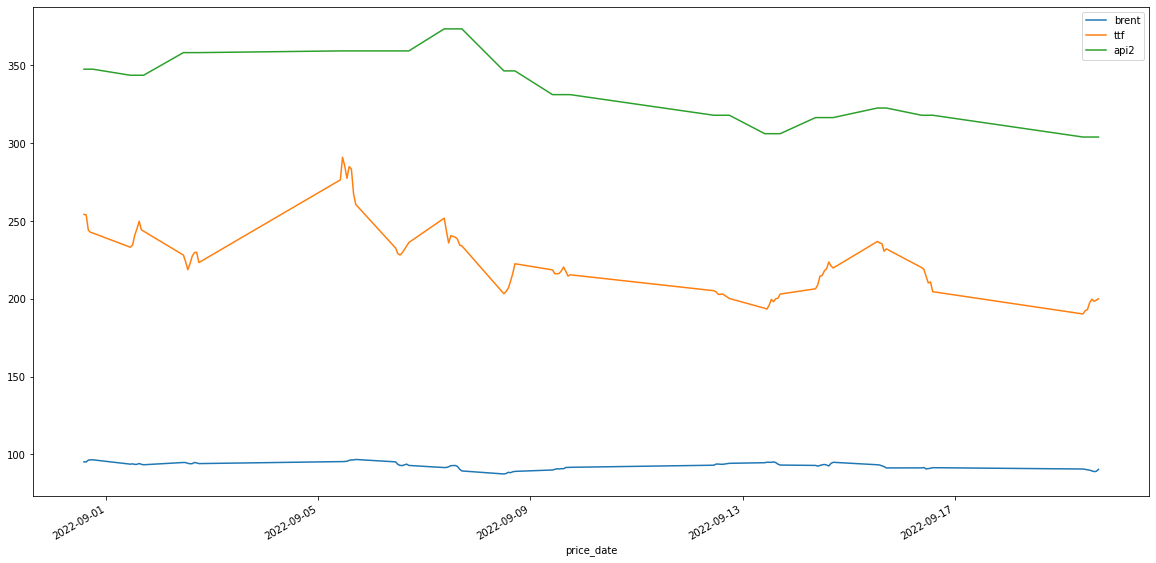

In [12]:
df_all_barchart_dropna.plot(figsize=(20,10))

<AxesSubplot:xlabel='price_date'>

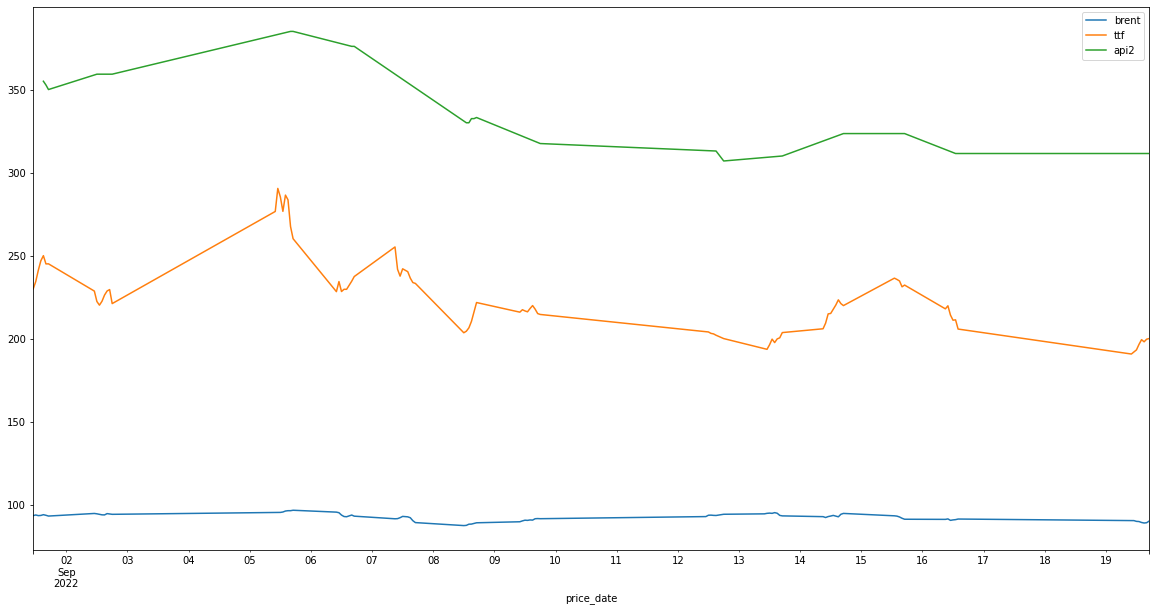

In [13]:
df_ice_interpolated.plot(figsize=(20,10))

<AxesSubplot:xlabel='price_date'>

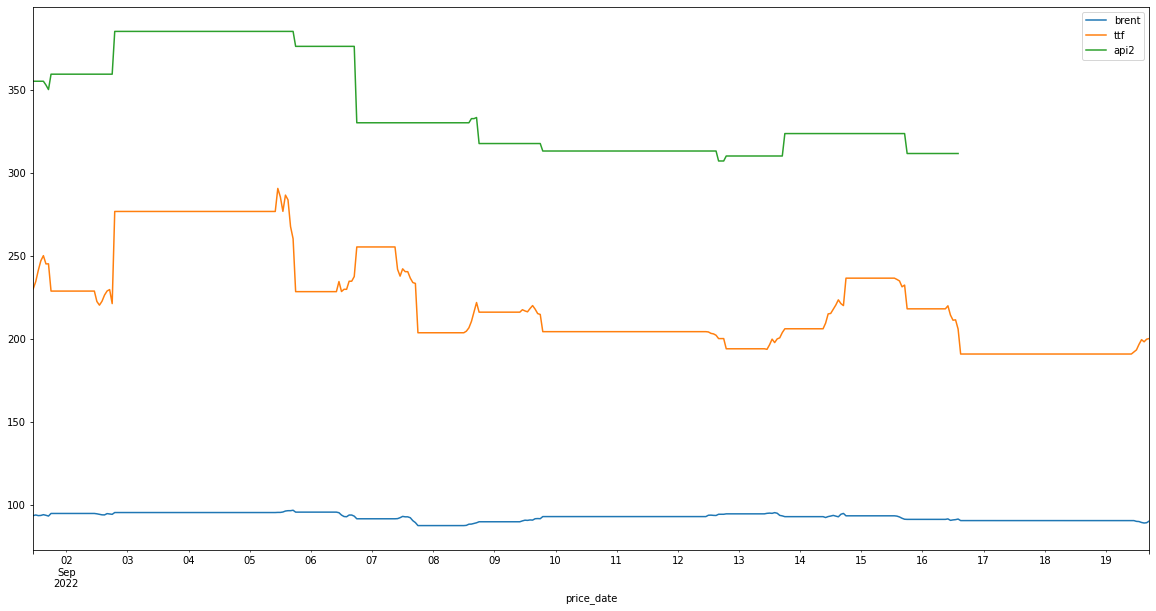

In [14]:
df_ice_bfill.plot(figsize=(20,10))

<AxesSubplot:xlabel='price_date'>

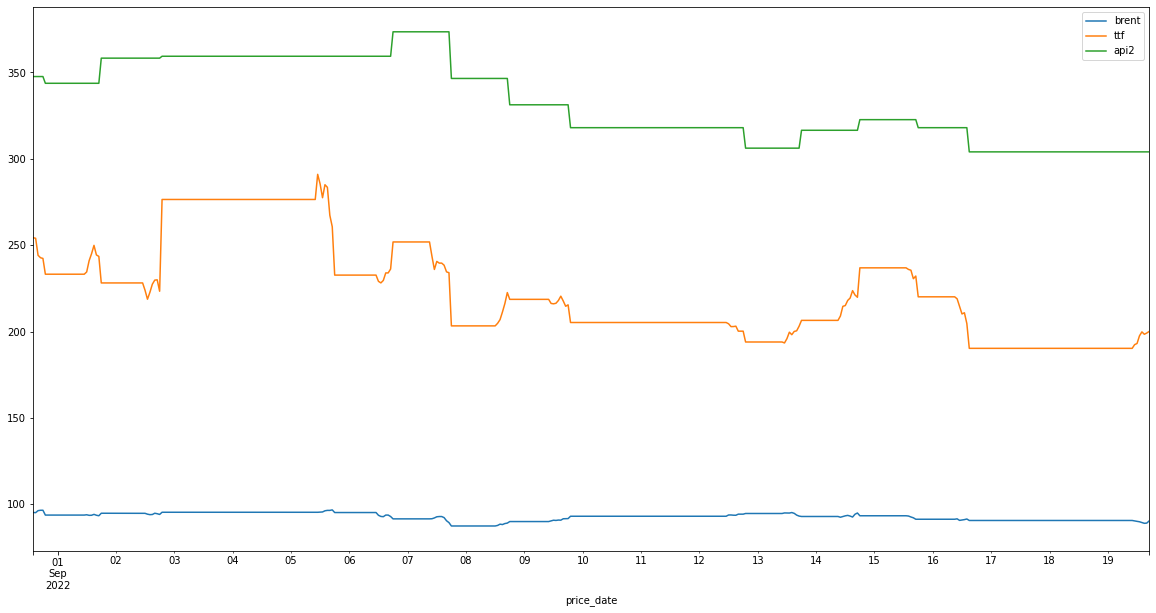

In [15]:
df_barchart_bfill.plot(figsize=(20,10))

In [16]:
df_barchart_log_return.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

C:\Users\cihat\AppData\Local\Temp\ipykernel_15356\3967419212.py:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  df_barchart_log_return.corr().style.background_gradient(cmap='coolwarm').set_precision(2)


,brent_log_return,ttf_log_return,api2_log_return
brent_log_return,1.00,0.20,0.08
ttf_log_return,0.20,1.00,0.44
api2_log_return,0.08,0.44,1.00


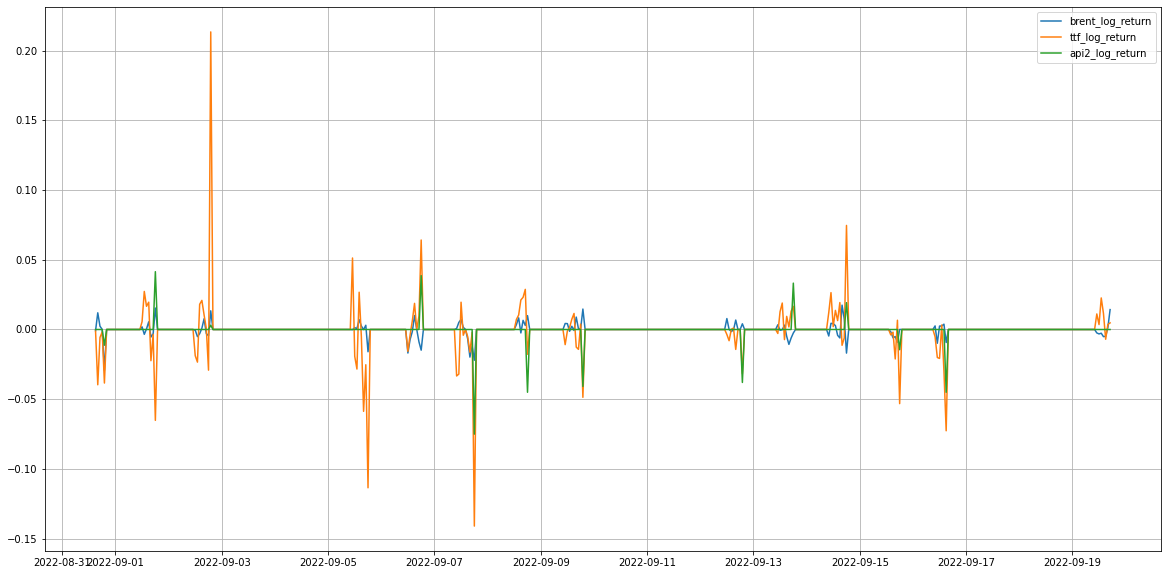

In [17]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
ax.plot(df_barchart_log_return)
ax.legend(df_barchart_log_return.columns)
ax.grid()
plt.show()